In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 23 15:30:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!7z x /content/drive/MyDrive/Classes.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 190278912 bytes (182 MiB)

Extracting archive: /content/drive/MyDrive/Classes.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Classes.zip
Type = zip
Physical Size = 190278912

  0%      5% 544 - Classes/ No_DR/4484_left.jpeg                                          9% 931 - Classes/ No_DR/7929_left.jpeg                                         12% 1273 - Classes/ No_DR/10786_left.jpeg

In [3]:
import pathlib
data_dir = '/content/Classes'
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [9]:
batch_size = 16
img_height = 299
img_width = 299

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
print(class_names)

[' No_DR', 'DR']


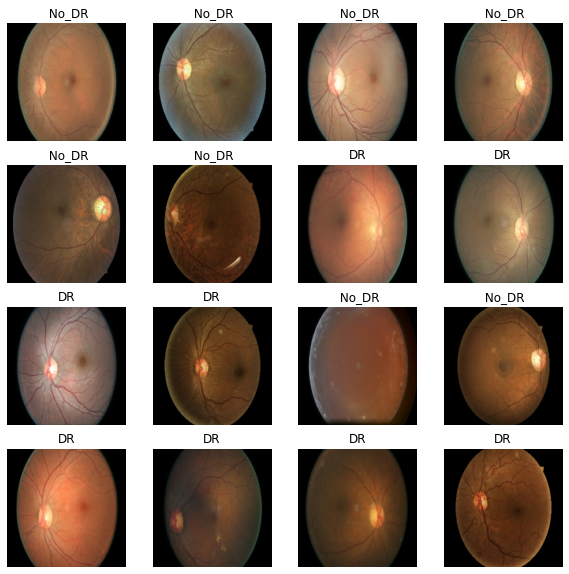

In [8]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

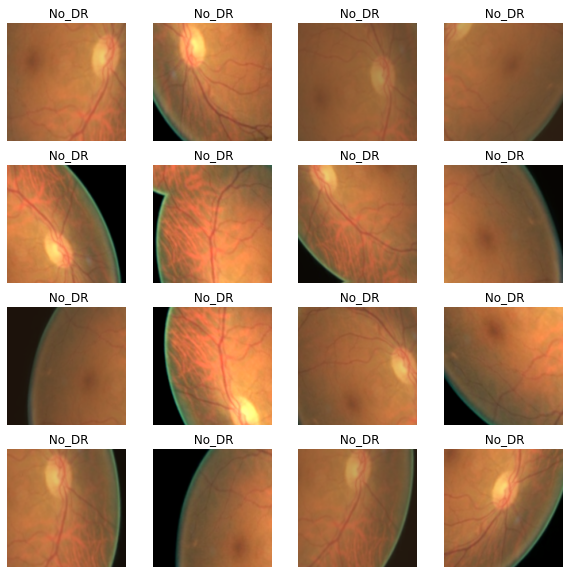

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [16]:
num_classes = len(class_names)

# Transfer Learning

In [15]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.models import Model

In [17]:
base_eff = model = EfficientNetV2L(weights='imagenet', include_top=False)
base_eff.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['rescaling[0][0]']              
                                32)                                                

In [18]:
base_eff.trainable = False

In [19]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_eff(image_batch)
print(feature_batch.shape)

(16, 10, 10, 1280)


In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 8)


In [22]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_eff(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
import time
start_cnn = time.time()

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_eff.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)

callback_list = [checkpoint,es]

In [29]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/50
451/451 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5984
Epoch 1: val_accuracy improved from -inf to 0.62989, saving model to best_model_eff.hdf5
451/451 [==============================] - 289s 589ms/step - loss: 0.6833 - accuracy: 0.5984 - val_loss: 0.6470 - val_accuracy: 0.6299
Epoch 2/50
451/451 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.6420
Epoch 2: val_accuracy improved from 0.62989 to 0.63733, saving model to best_model_eff.hdf5
451/451 [==============================] - 253s 562ms/step - loss: 0.6315 - accuracy: 0.6420 - val_loss: 0.6423 - val_accuracy: 0.6373
Epoch 3/50
451/451 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.6494
Epoch 3: val_accuracy did not improve from 0.63733
451/451 [==============================] - 251s 556ms/step - loss: 0.6235 - accuracy: 0.6494 - val_loss: 0.6311 - val_accuracy: 0.6360
Epoch 4/50
451/451 [==============================] - ETA: 0s - loss: 0.615

In [30]:
print("Total time: ", time.time() - start_cnn, "seconds")

Total time:  5697.742737293243 seconds


In [31]:
scores = model.evaluate(train_ds)

451/451 [==============================] - 177s 392ms/step - loss: 0.5673 - accuracy: 0.7030


In [32]:
scores = model.evaluate(val_ds)

194/194 [==============================] - 76s 389ms/step - loss: 0.6098 - accuracy: 0.6619


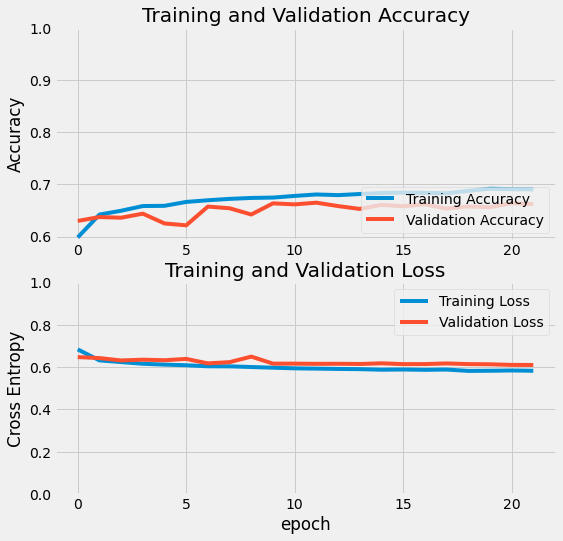

In [33]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label:  No_DR
1/1 [==============================] - 6s 6s/step
[7.7469492e-01 2.2530478e-01 2.0016209e-08 3.2182431e-08 2.8433094e-08
 3.5882724e-08 2.5200130e-08 5.0742116e-08]
predicted label:  No_DR


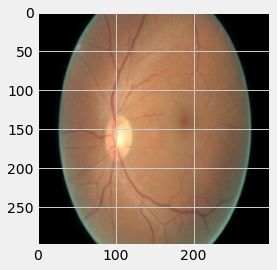

In [34]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[5])
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


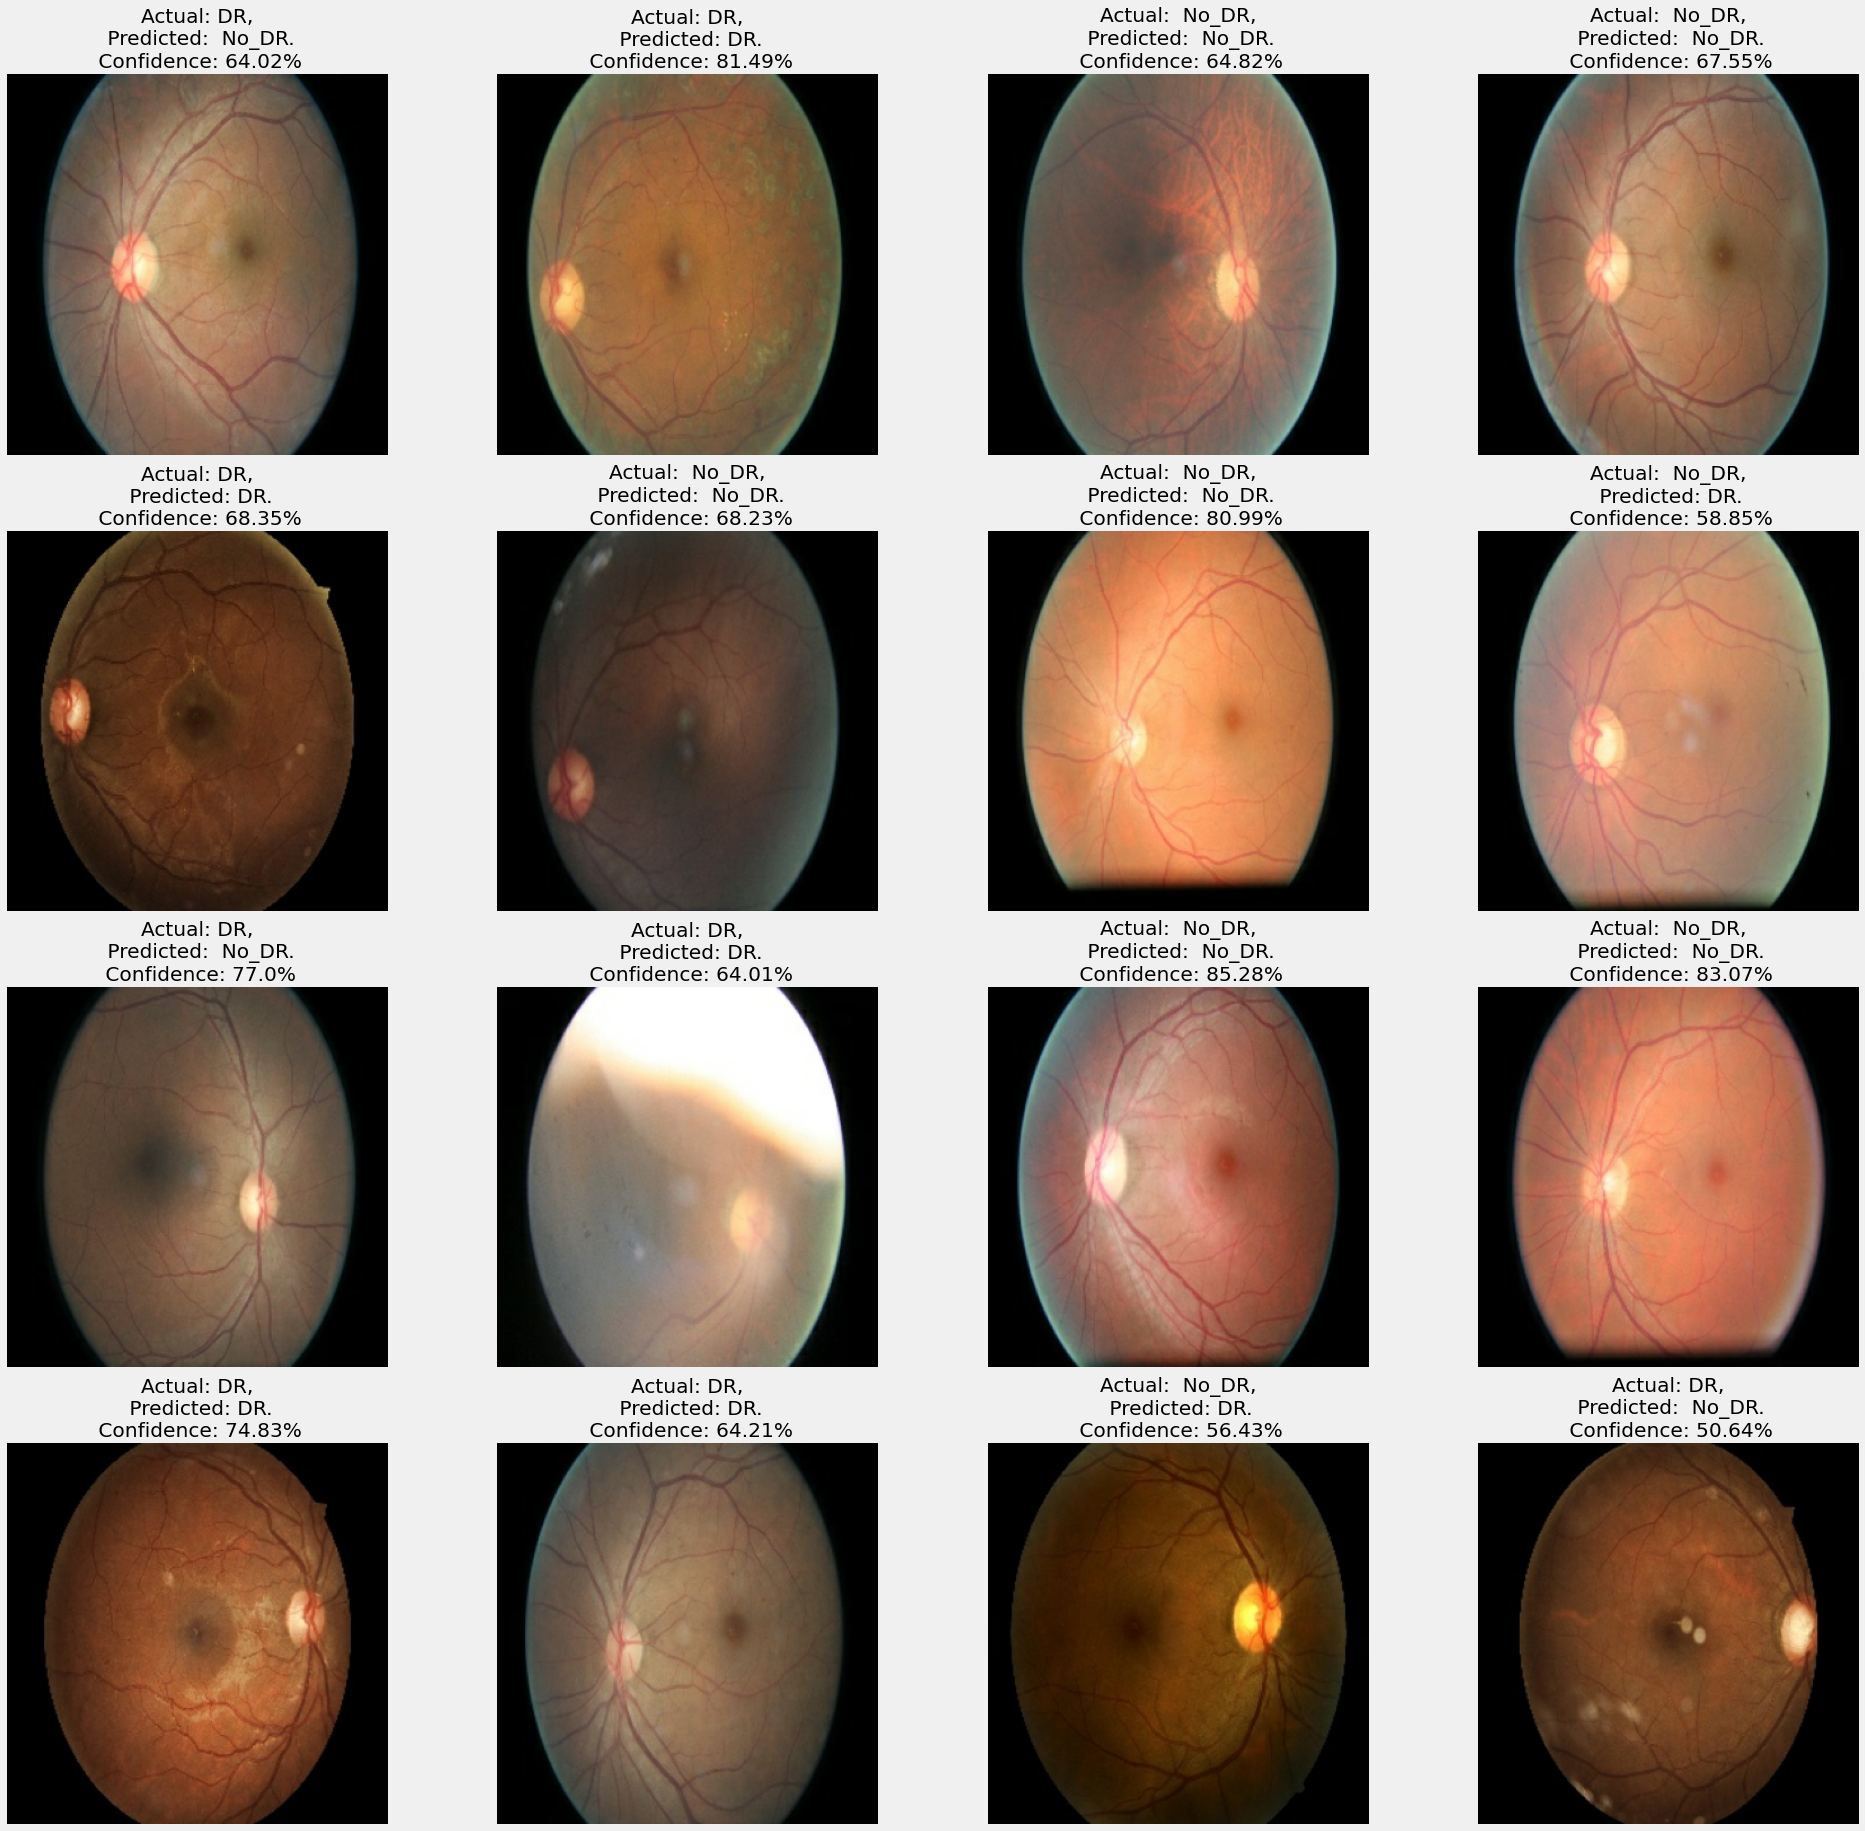

In [36]:
plt.figure(figsize=(30, 30))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [37]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [38]:
x = np.array(X)

In [39]:
y = np.array(y)

In [40]:
x.shape, y.shape

((1523, 299, 299, 3), (1523,))

In [41]:
model.evaluate(x[:1400],y[:1400])

44/44 [==============================] - 39s 834ms/step - loss: 0.6101 - accuracy: 0.6614


[0.6101132035255432, 0.6614285707473755]

In [42]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:1400])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:1400], y_pred_classes))

44/44 [==============================] - 32s 733ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.70      0.68       704
           1       0.67      0.62      0.65       696

    accuracy                           0.66      1400
   macro avg       0.66      0.66      0.66      1400
weighted avg       0.66      0.66      0.66      1400

